# Triage network workflow

Tested with Python 3.6.7 (from miniconda)

## Part 0. Dependencies

In [1]:
%%bash

pip install numpy seaborn sklearn-evaluation tensorflow
pip install git+git://github.com/edublancas/dstools
pip install git+git://github.com/paninski-lab/yass@8ddce299fe52901af0b35f3a49dda86f61ca2c6e

  Cloning git://github.com/edublancas/dstools to /tmp/pip-req-build-7p1aal_t
  Running setup.py bdist_wheel for dstools: started
  Running setup.py bdist_wheel for dstools: finished with status 'done'
  Stored in directory: /tmp/pip-ephem-wheel-cache-ueerohwt/wheels/14/03/84/2653443c3733108ee938002fcf091d55e62ca7f0f556a91a55
Successfully built dstools
  Cloning git://github.com/paninski-lab/yass (to revision 8ddce299fe52901af0b35f3a49dda86f61ca2c6e) to /tmp/pip-req-build-_1p6uy7n
  Running setup.py bdist_wheel for yass-algorithm: started
  Running setup.py bdist_wheel for yass-algorithm: finished with status 'done'
  Stored in directory: /tmp/pip-ephem-wheel-cache-1471nvei/wheels/ed/6c/1f/1b7803bcf22d8ec9b2737decea7df1b6f94d36e4837ce612b6
Successfully built yass-algorithm


In [22]:
%%bash

mkdir -p /tmp/spike-sorting
curl https://dl.dropboxusercontent.com/s/sylnygjmcvkmi4z/templates.npy?dl=0 -o /tmp/spike-sorting/templates.npy
curl https://dl.dropboxusercontent.com/s/smk83ob73y9z7p0/config.yaml?dl=0 -o /tmp/spike-sorting/config.yaml
curl https://dl.dropboxusercontent.com/s/mfp5vcu9b53ws91/noise_cov.npz?dl=0 -o /tmp/spike-sorting/noise_cov.npz
curl https://dl.dropboxusercontent.com/s/k9qa7vttuzrsmr4/geometry.txt?dl=0 -o /tmp/spike-sorting/geometry.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2802k  100 2802k    0     0  3051k      0 --:--:-- --:--:-- --:--:-- 3049k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   274  100   274    0     0    532      0 --:--:-- --:--:-- --:--:--   533
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30652  100 30652    0     0  48159      0 --:--:-- --:--:-- --:--:-- 48119
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   680  100   680    0     0   1507      0 --:--:-- --:--:-- --:--:--  1511


## Part 1. Train/Test set creation

In [24]:
import datetime
import logging
from pathlib import Path
from os.path import expanduser
from os import path

import yass
from yass import read_config
from yass.augment import make
from yass.neuralnetwork import NeuralNetTriage
from yass.batch import RecordingsReader
from yass.augment.noise import noise_cov
from yass.templates import TemplatesProcessor
from yass.geometry import make_channel_index


import seaborn as sns
import numpy as np
from dstools import plot
import sklearn_evaluation.plot as skplot

# logging.basicConfig(level=logging.DEBUG)

In [25]:
path_to_data = expanduser('~/data')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')

In [33]:
yass.set_config('/tmp/spike-sorting/config.yaml',
                '/tmp/spike-sorting/output')
CONFIG = read_config()

### 1.1 Loading templates

In [29]:
raw_templates = np.load('/tmp/spike-sorting/templates.npy')
n_templates, waveform_length, _ = raw_templates.shape
print(raw_templates.shape)

(240, 61, 49)


In [30]:
# crop spatially
processor = TemplatesProcessor(raw_templates)
templates = (processor
            .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
            .values)
templates.shape

(240, 61, 7)

/home/Edu/miniconda3/envs/py36/lib/python3.6/site-packages/dstools/plot/plot.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicer]


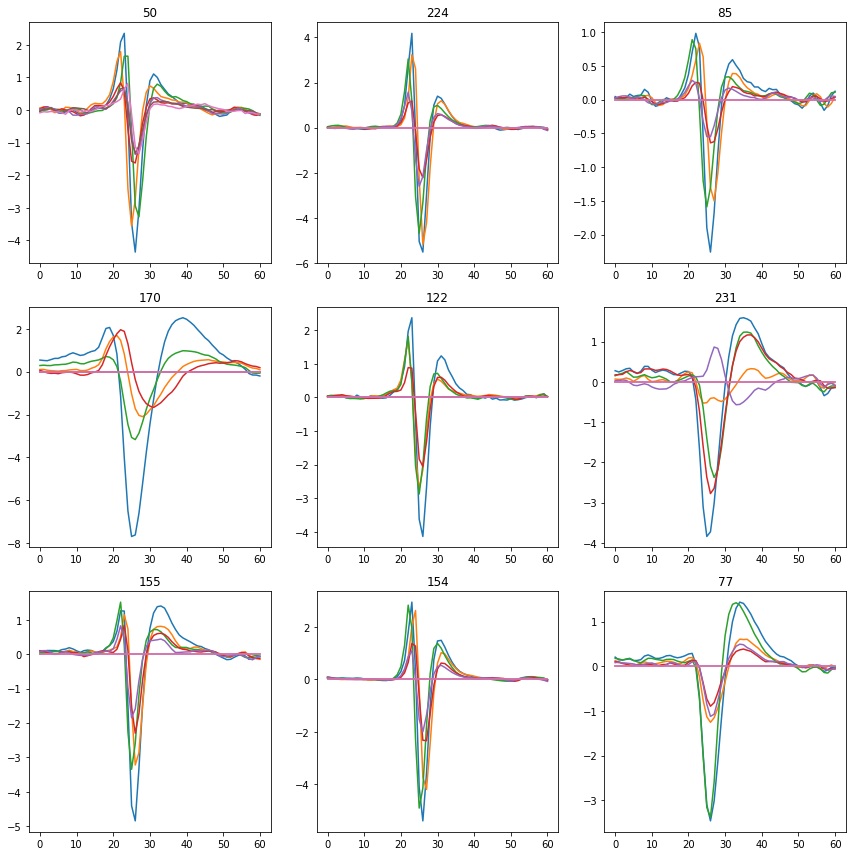

In [8]:
plot.grid_from_array(templates, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

### 1.2 Estimating noise covariance structure

In [9]:
ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [31]:
LOAD_NOISE_COV = True


if LOAD_NOISE_COV:
    cov = np.load('/tmp/spike-sorting/noise_cov.npz')
    spatial_sig, temporal_sig = cov['spatial_sig'], cov['temporal_sig']
else:
    rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]
    (spatial_sig,
     temporal_sig) = noise_cov(rec, templates.shape[1], templates.shape[1])

### 1.3 Make dataset

In [11]:
min_amplitude = 4
max_amplitude = 60

n_clean_per_template = 150
n_collided_per_spike = 1
max_shift = 15
min_shift = 4

probabilities = (0.8, 0.05, 0.05, 0.05, 0.05)

In [12]:
X, y = make.training_data_triage(templates,
                                       min_amplitude,
                                       max_amplitude,
                                       n_clean_per_template,
                                       n_collided_per_spike,
                                       max_shift,
                                       min_shift,
                                       spatial_sig,
                                       temporal_sig,
                                       {'probabilities': probabilities},
                                       {'return_metadata': True})

In [13]:
X.shape, y.shape

((72000, 61, 7), (72000,))

### 1.4 Plot some examples

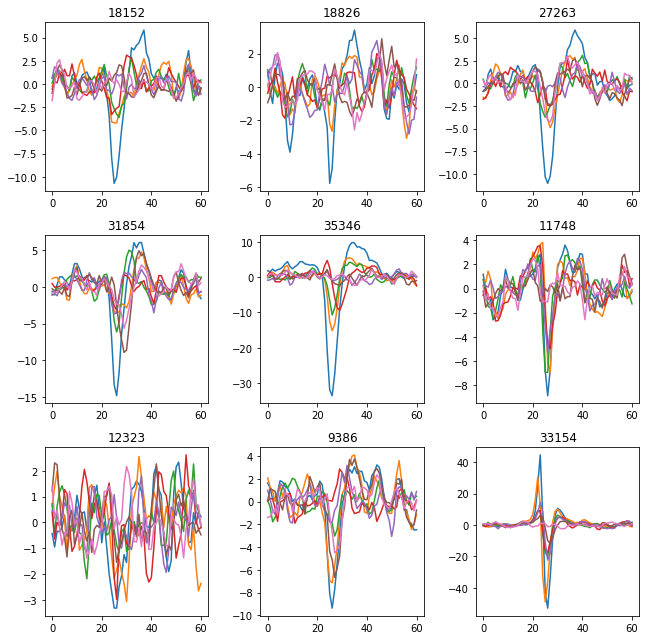

In [14]:
# positive examples: single spikes
plot.grid_from_array(X[y == 1], axis=0,
                     elements=9, auto_figsize=3)

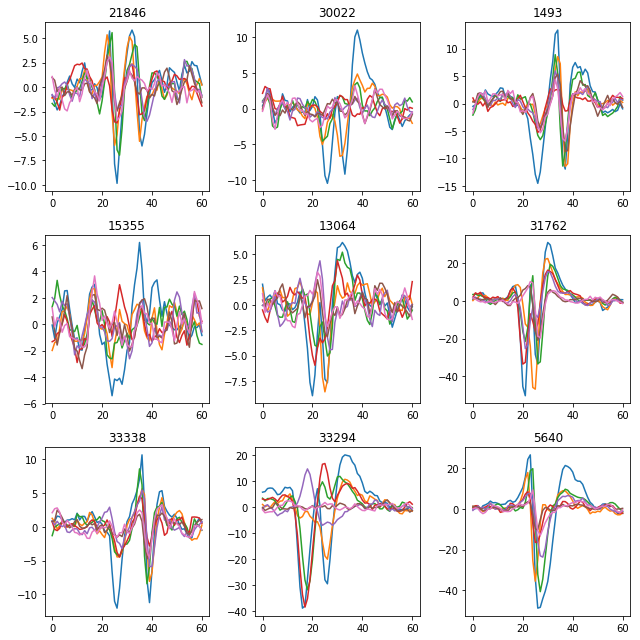

In [15]:
# negative examples: collisions
plot.grid_from_array(X[y == 0], axis=0,
                     elements=9, auto_figsize=3)

## Part 2. Network training

In [16]:
filters_size = [64, 32]
threshold = 0.5
_, waveform_length, n_neighbors =  X.shape

model = NeuralNetTriage('/tmp/spike-sorting/my-triage-network.ckpt', filters_size,
                        waveform_length, n_neighbors, threshold,
                        n_iter=5000, n_batch=512, l2_reg_scale=0.00000005,
                        train_step_size=0.001)

In [17]:
model.fit(X, y)

Tr loss: 0.0028716105, Val loss: 0.03162906: 100%|██████████| 5000/5000 [00:55<00:00, 90.23it/s]  


{'filters_size': [64, 32],
 'waveform_length': 61,
 'n_neighbors': 7,
 'name': 'my-triage-network',
 'tn': 0.9960514233241506,
 'fp': 0.004014939309056956,
 'fn': 0.01992653810835629,
 'tp': 0.9797385620915032,
 'acc': 0.9879629629629629,
 'prec': 0.9959187547456341,
 'rec': 0.9797385620915032,
 'metadata': {'yass_version': '0.10dev'}}

### Part 3. Network evaluation

In [18]:
preds = model.predict(model.x_test)

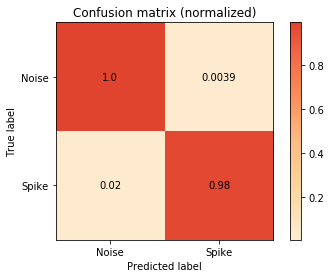

In [19]:
skplot.confusion_matrix(model.y_test, preds, normalize=True, target_names=['Noise', 'Spike'])

### Part 4. Cleanup

In [34]:
! rm -rf /tmp/spike-sorting